In [46]:
import itertools

import numpy.random as random
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit, ParameterGrid
from keras.models import Sequential
from keras.layers import Dense
from keras import activations, optimizers, regularizers, losses, initializers
from functools import partial

pd.set_option('display.max_rows', None)

What is the lower bound for the number of training examples, N?
- N >= n
- lower bound is amount of rbf kernels n

What happens with the error if N = n? Why?
- if we have as many rbf kernels n as samples N then we are overfitting, each rbf kernel can select one sample as its prototype vector and the error is 0

Under what conditions, if any, does (4) have a solution in this case?
- ??

During training we use an error measure defined over the training examples. Is it good to use this measure when evaluating the performance of the network? Explain!
- No, because we don't get information about the generalization error.
- We do not notice if we overfit or not, if we do not use validation / test sets.


# 3.1 Supervised learning of RBF NN

In [47]:
def sin_function(x):
    return np.sin(2 * x).reshape(-1, 1)


def square_function(x):
    a = (np.sin(2 * x) >= 0).astype(float).reshape(-1, 1)
    a[a == 0] = -1
    return a


def generate_X(start=0, stop=2 * np.pi, step_size=0.1):
    return np.arange(start, stop, step_size).reshape(-1, 1)


def get_train_data(noise=False):
    X_train = generate_X()
    y_train_sin = sin_function(X_train)
    y_train_square = square_function(X_train)

    if noise:
        X_train += np.random.normal(0, 0.1, (len(X_train), 1))
        y_train_sin += np.random.normal(0, 0.1, (len(X_train), 1))
        y_train_square += np.random.normal(0, 0.1, (len(X_train), 1))

    return X_train, y_train_sin, y_train_square


def get_test_data(noise=False):
    X_test = generate_X(start=0.05)
    y_test_sin = sin_function(X_test)
    y_test_square = square_function(X_test)

    if noise:
        X_test += np.random.normal(0, 0.1, (len(X_test), 1))
        y_test_sin += np.random.normal(0, 0.1, (len(X_test), 1))
        y_test_square += np.random.normal(0, 0.1, (len(X_test), 1))

    return X_test, y_test_sin, y_test_square


fixed_std = 0.4


def get_rbf_kernels(num, std=fixed_std):
    number_of_kernel = num

    rbf_center_sin = np.linspace(start=0, stop=2 * np.pi, num=number_of_kernel)
    y_rbf_sin = sin_function(rbf_center_sin)

    rbf_center_square = np.linspace(start=0, stop=2 * np.pi, num=number_of_kernel)
    y_rbf_square = square_function(rbf_center_square)

    kernel_stds = std * np.ones((len(rbf_center_square),)).reshape(-1, 1)

    return kernel_stds, rbf_center_sin, rbf_center_square, y_rbf_sin, y_rbf_square


X_train, y_train_sin, y_train_square = get_train_data()
X_test, y_test_sin, y_test_square = get_test_data()
kernel_stds, rbf_center_sin, rbf_center_square, y_rbf_sin, y_rbf_square = get_rbf_kernels(10)

residual_error_thresholds = [0.1, 0.01, 0.001]

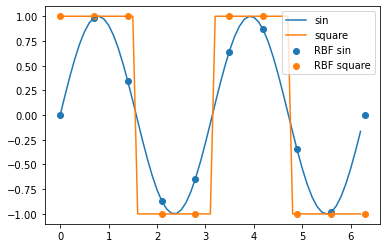

In [48]:
plt.plot(X_train, y_train_sin, label="sin")
plt.plot(X_train, y_train_square, label="square")
plt.scatter(rbf_center_sin, y_rbf_sin, label="RBF sin")
plt.scatter(rbf_center_square, y_rbf_square, label="RBF square")
plt.legend()
plt.show()


In [49]:

def plot_rbf_with_data(rbf, X, y):
    y_pred = rbf.predict(X)

    plt.plot(X, y, label="Sin")
    plt.scatter(rbf.kernel_centers, sin_function(rbf.kernel_centers), label="RBF")
    plt.plot(X, y_pred, label="Pred")
    plt.legend()
    plt.show()


In [81]:
class RBFNet:
    def __init__(self, kernel_centers=None, kernel_stds=None, k=None,
                 delta_lr=0.01, cl_lr=0.3, delta_epochs=1, cl_epochs=100):
        self.delta_lr = delta_lr
        self.cl_lr = cl_lr
        self.delta_epochs = delta_epochs
        self.cl_epochs = cl_epochs
        self.kernel_centers = kernel_centers
        self.kernel_stds = kernel_stds
        if kernel_centers is None:
            self.k = k
        else:
            self.k = len(kernel_centers)
        self.w = self.init_weights()

    def rbf_function(self, x, center, std):
        return np.exp(-((x - center) ** 2) / (2 * std ** 2))

    def calc_expanded_X(self, X):
        if np.ndim(np.squeeze(X)) == 0:
            phi = np.array(
                [self.rbf_function(np.squeeze(X), c, s) for c, s, in zip(self.kernel_centers, self.kernel_stds)]).reshape(-1, 1)
            assert phi.shape == (self.k, 1)
            return phi

        rows = []
        for i in range(X.shape[0]):
            row = [self.rbf_function(X[i], c, s) for c, s, in zip(self.kernel_centers, self.kernel_stds)]
            rows.append(row)
        phi = np.hstack(rows).T  # vstack does not work :((((((((
        assert phi.shape == (X.shape[0], self.k)
        return phi

    def forward_pass(self, X):
        phi = self.calc_expanded_X(X)
        if phi.shape == (self.k, 1):
            return phi.T @ self.w
        return phi @ self.w

    def sum_of_squared_diff(self, y_pred, y_true):
        return np.sum((y_pred - y_true) ** 2)

    def mean_absolute_error(self, y_pred, y_true):
        return 1 / len(y_pred) * np.sum(np.abs(y_pred - y_true))

    def perceptron_batch_learning(self, X, y):
        phi = self.calc_expanded_X(X)
        inv_cov = np.linalg.inv(phi.T @ phi)
        self.w = inv_cov @ phi.T @ y
        assert self.w.shape == (self.k, 1)

    def shuffle(self, X, y):
        to_shuffle = np.column_stack((X, y))
        np.random.shuffle(to_shuffle)
        _X = np.array([to_shuffle[:, 0]]).reshape(-1, 1)
        _y = np.array([to_shuffle[:, 1]]).reshape(-1, 1)
        return _X, _y

    def delta_online_learning(self, X, y, cl=None):  # sequential
        X, y = self.shuffle(X, y)

        for i in range(len(X)):
            _x, _y = np.squeeze(X[i, :]), np.squeeze(y[i, :])
            error = np.squeeze(_y - self.forward_pass(_x))
            if np.ndim(np.squeeze(error)) == 0:
                w_delta = self.delta_lr * error * self.calc_expanded_X(_x)
            else:
                w_delta = self.delta_lr * error @ self.calc_expanded_X(_x)
            assert w_delta.shape == (self.k, 1)
            self.w += w_delta

        assert self.w.shape == (self.k, 1)

    def init_weights(self):
        self.w = np.random.randn(self.k, 1)

    def fit(self, X, y, rule="perceptron", cl=None):
        # init
        if self.kernel_centers is None:
            if cl is None:
                self.init_random_prototype_vectors(X)
            else:
                self.init_rbf_kernels_with_cl(X, cl)
        self.init_weights()

        # learn
        for epoch in range(self.delta_epochs):
            if rule == "delta":
                self.delta_online_learning(X, y, cl)
            else:
                self.perceptron_batch_learning(X, y)

        y_pred = self.forward_pass(X)
        loss = self.sum_of_squared_diff(y_pred, y)
        print(f"Loss: {loss:.4f}")

    def predict(self, X, sign=False):
        y_pred = self.forward_pass(X)
        if sign:
            y_pred = np.sign(y_pred)
        return y_pred

    def fit_and_predict(self, X, y, rule="perceptron", cl=None, sign=False):
        self.fit(X, y, rule, cl)
        return self.predict(X, sign)

    def evaluate_residual_error(self, X, y, sign=False):
        y_pred = self.predict(X, sign)
        loss = self.mean_absolute_error(y_pred, y)
        print(f"Residual Error (MAE): {loss:.4f}")
        return loss

    def init_rbf_kernels_with_cl(self, X, mode="hard"):
        self.init_random_prototype_vectors(X)
        if mode == "hard":
            for epoch in range(self.cl_epochs):
                rnd = np.random.randint(len(X))
                rnd_sample = X[rnd]
                print(rnd_sample)
                # update prototype vectors
                near_index = self.get_index_nearest_rbf_kernel(rnd_sample)

                delta = self.cl_lr * (rnd_sample - self.kernel_centers[near_index])
                self.kernel_centers[near_index] += delta

        else:  # soft
            pass

        self.init_kernel_stds(X)

    def get_index_nearest_rbf_kernel(self, sample):
        dist = self.kernel_centers - sample
        min_index = np.argmin(dist)
        return min_index

    def init_random_prototype_vectors(self, X):
        rnd_samples = X[np.random.randint(low=len(X), size=self.k)]
        self.kernel_centers = rnd_samples
        self.init_kernel_stds(X)

    def nearest_kernel(self, X):
        distances = np.squeeze(np.abs(X[:, np.newaxis] - self.kernel_centers[np.newaxis, :]))
        closest_kernel = np.argmin(distances, axis=1)
        return closest_kernel

    def init_kernel_stds(self, X):
        fix_stds = False
        stds = []
        closest_kernels = self.nearest_kernel(X)

        for i in range(self.k):
            points_for_kernel = X[closest_kernels == i]
            if len(points_for_kernel) >= 2:
                std = np.std(X[closest_kernels == i])
                stds.append(std)
            else:
                fix_stds = True
                stds.append(0)

        stds = np.array(stds).reshape(-1, )

        if fix_stds:
            # set clusters with std = 0 to mean std of other kernels
            mean = np.mean(stds[stds != 0])
            stds[stds == 0] = mean

        self.kernel_stds = stds


Kernels 1
Loss: 55.4882
Residual Error (MAE): 0.9841
Residual Error (MAE): 0.9152

Kernels 2
Loss: 48.6703
Residual Error (MAE): 0.9841
Residual Error (MAE): 0.8299

Kernels 3
Loss: 48.6663
Residual Error (MAE): 0.5714
Residual Error (MAE): 0.8303

Kernels 4
Loss: 29.2807
Residual Error (MAE): 0.3175
Residual Error (MAE): 0.5702

Kernels 5
Loss: 48.4786
Residual Error (MAE): 0.5714
Residual Error (MAE): 0.8317

Kernels 6
Loss: 17.3478
Residual Error (MAE): 0.1270
Residual Error (MAE): 0.4000

Kernels 7
Loss: 11.4507
Residual Error (MAE): 0.0635
Residual Error (MAE): 0.3090

Kernels 8
Loss: 8.9279
Residual Error (MAE): 0.0635
Residual Error (MAE): 0.2786

Kernels 9
Loss: 11.6731
Residual Error (MAE): 0.0635
Residual Error (MAE): 0.3327

Kernels 10
Loss: 8.9795
Residual Error (MAE): 0.0000
Residual Error (MAE): 0.2673

Kernels 11
Loss: 8.0813
Residual Error (MAE): 0.0317
Residual Error (MAE): 0.2399

Kernels 12
Loss: 6.0415
Residual Error (MAE): 0.0635
Residual Error (MAE): 0.2132

Kerne

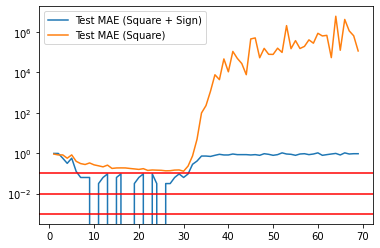

In [297]:

X_train, y_train_sin, y_train_square = get_train_data()
X_test, y_test_sin, y_test_square = get_test_data()

num_of_kernels = np.arange(1, 70, 1)
square_sign_maes = []
square_maes = []

for k in num_of_kernels:
    print(f"Kernels {k}")
    kernel_stds, rbf_center_sin, rbf_center_square, y_rbf_sin, y_rbf_square = get_rbf_kernels(num=k)

    rbf_square = RBFNet(kernel_centers=rbf_center_square, kernel_stds=kernel_stds)
    y_pred_square = rbf_square.fit_and_predict(X_train, y_train_square, sign=True)

    square_sign_test_loss = rbf_square.evaluate_residual_error(X_test, y_test_square, sign=True)
    square_test_loss = rbf_square.evaluate_residual_error(X_test, y_test_square, sign=False)

    square_sign_maes.append(square_sign_test_loss)
    square_maes.append(square_test_loss)
    print("")

plt.plot(num_of_kernels, square_sign_maes, label="Test MAE (Square + Sign)")
plt.plot(num_of_kernels, square_maes, label="Test MAE (Square)")
plt.axhline(y=residual_error_thresholds[0], c="r")
plt.axhline(y=residual_error_thresholds[1], c="r")
plt.axhline(y=residual_error_thresholds[2], c="r")
plt.yscale('log')
#plt.yticks([0.1, 0.01, 0.001])
plt.legend()
plt.show()


Loss: 4.7853
Residual Error (MAE): 0.0000


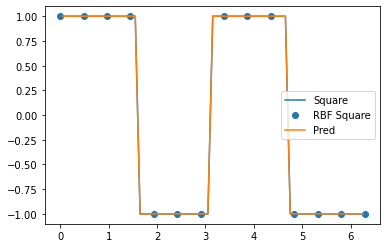

In [298]:
kernel_stds, rbf_center_sin, rbf_center_square, y_rbf_sin, y_rbf_square = get_rbf_kernels(num=14)

rbf_square = RBFNet(kernel_centers=rbf_center_square, kernel_stds=kernel_stds)
y_pred_square = rbf_square.fit_and_predict(X_train, y_train_square, sign=True)

square_test_loss = rbf_square.evaluate_residual_error(X_test, y_test_square, sign=True)

y_pred_test = rbf_square.predict(X_test, sign=True)

plt.plot(X_test, y_test_square, label="Square")
plt.scatter(rbf_center_square, y_rbf_square, label="RBF Square")
plt.plot(X_test, y_pred_test, label="Pred")
plt.legend()
plt.show()


Kernels 1
Loss: 29.7702
Residual Error (MAE): 0.6122

Kernels 2
Loss: 27.6745
Residual Error (MAE): 0.5925

Kernels 3
Loss: 27.6745
Residual Error (MAE): 0.5925

Kernels 4
Loss: 16.4281
Residual Error (MAE): 0.4363

Kernels 5
Loss: 27.6711
Residual Error (MAE): 0.5926

Kernels 6
Loss: 7.0714
Residual Error (MAE): 0.2843

Kernels 7
Loss: 3.0557
Residual Error (MAE): 0.1889

Kernels 8
Loss: 0.9057
Residual Error (MAE): 0.1047

Kernels 9
Loss: 0.1881
Residual Error (MAE): 0.0486

Kernels 10
Loss: 0.0378
Residual Error (MAE): 0.0201

Kernels 11
Loss: 0.0167
Residual Error (MAE): 0.0104

Kernels 12
Loss: 0.0129
Residual Error (MAE): 0.0090

Kernels 13
Loss: 0.0103
Residual Error (MAE): 0.0084

Kernels 14
Loss: 0.0074
Residual Error (MAE): 0.0073

Kernels 15
Loss: 0.0055
Residual Error (MAE): 0.0064

Kernels 16
Loss: 0.0036
Residual Error (MAE): 0.0052

Kernels 17
Loss: 0.0025
Residual Error (MAE): 0.0044

Kernels 18
Loss: 0.0015
Residual Error (MAE): 0.0035

Kernels 19
Loss: 0.0010
Residual

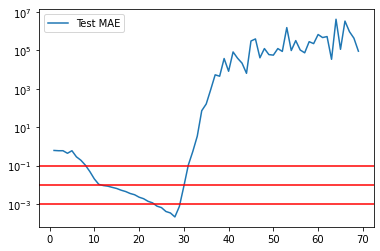

In [299]:

X_train, y_train_sin, y_train_square = get_train_data()
X_test, y_test_sin, y_test_square = get_test_data()

num_of_kernels = np.arange(1, 70, 1)
sin_maes = []

for k in num_of_kernels:
    print(f"Kernels {k}")
    kernel_stds, rbf_center_sin, rbf_center_square, y_rbf_sin, y_rbf_square = get_rbf_kernels(num=k)

    rbf_sin = RBFNet(kernel_centers=rbf_center_sin, kernel_stds=kernel_stds)
    y_pred_sin = rbf_sin.fit_and_predict(X_train, y_train_sin)

    sin_test_loss = rbf_sin.evaluate_residual_error(X_test, y_test_sin)

    sin_maes.append(sin_test_loss)
    print("")

plt.plot(num_of_kernels, sin_maes, label="Test MAE")
plt.axhline(y=residual_error_thresholds[0], c="r")
plt.axhline(y=residual_error_thresholds[1], c="r")
plt.axhline(y=residual_error_thresholds[2], c="r")
plt.yscale('log')
#plt.yticks([0.1, 0.01, 0.001])
plt.legend()
plt.show()


Loss: 0.0036
Residual Error (MAE): 0.0052


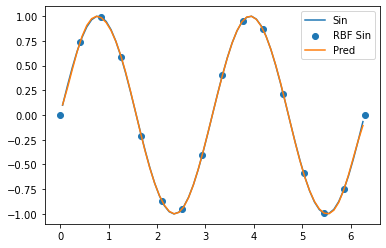

In [300]:
kernel_stds, rbf_center_sin, rbf_center_square, y_rbf_sin, y_rbf_square = get_rbf_kernels(num=16)

rbf_sin = RBFNet(kernel_centers=rbf_center_sin, kernel_stds=kernel_stds)
y_pred_sin = rbf_sin.fit_and_predict(X_train, y_train_sin)

sin_test_loss = rbf_sin.evaluate_residual_error(X_test, y_test_sin)
y_pred_test = rbf_sin.predict(X_test)

plt.plot(X_test, y_test_sin, label="Sin")
plt.scatter(rbf_center_sin, y_rbf_sin, label="RBF Sin")
plt.plot(X_test, y_pred_test, label="Pred")
plt.legend()
plt.show()


How can you simply transform the output of your RBF network to reduce the residual error to 0 for the square(2x) problem? Still, how many units do you need? In what type of applications could this transform be particularly useful?
- sign activation function to {-1, 1}
- classification
- 30 units for test set residual error = 0


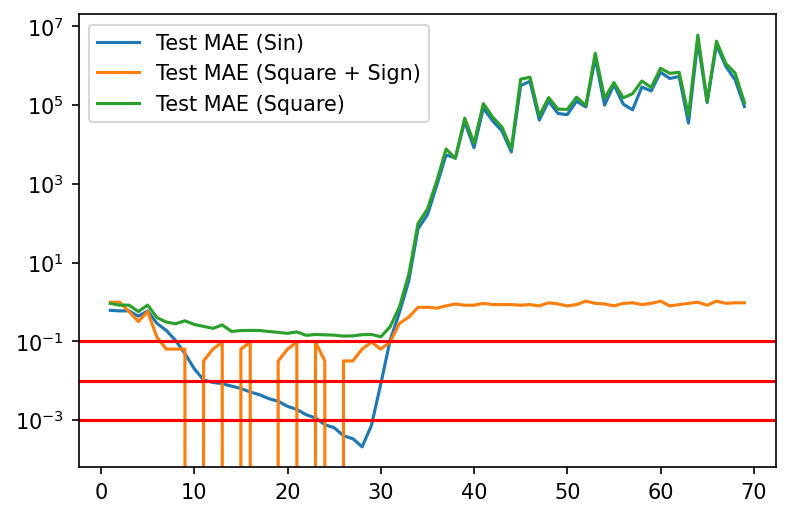

In [301]:
plt.figure(figsize=(6, 4), dpi=150)

plt.plot(num_of_kernels, sin_maes, label="Test MAE (Sin)")
plt.plot(num_of_kernels, square_sign_maes, label="Test MAE (Square + Sign)")
plt.plot(num_of_kernels, square_maes, label="Test MAE (Square)")
plt.axhline(y=residual_error_thresholds[0], c="r")
plt.axhline(y=residual_error_thresholds[1], c="r")
plt.axhline(y=residual_error_thresholds[2], c="r")
plt.yscale('log')
#plt.yticks([0.1, 0.01, 0.001])
plt.legend()
plt.show()


# 3.2 Regression with noise

Loss: 0.3276
Residual Error (MAE): 0.0633


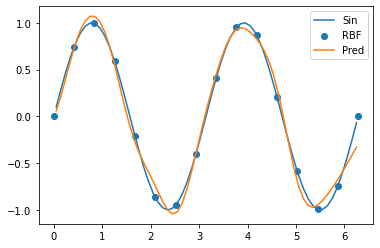

In [82]:

X_train, y_train_sin, y_train_square = get_train_data()  #noise=True)
X_test, y_test_sin, y_test_square = get_test_data()  #noise=True)

kernel_stds, rbf_center_sin, rbf_center_square, y_rbf_sin, y_rbf_square = get_rbf_kernels(num=16)

rbf_noise = RBFNet(kernel_centers=rbf_center_sin, kernel_stds=kernel_stds, delta_epochs=100)
y_pred_train_sin = rbf_noise.fit_and_predict(X_train, y_train_sin, rule="delta")

sin_test_loss = rbf_noise.evaluate_residual_error(X_test, y_test_sin)
y_pred_test_sin = rbf_noise.predict(X_test)

plot_rbf_with_data(rbf_noise, X_test, y_test_sin)

# 3.3 Competitive learning to initialize RBF

[3.8]
[0.6]
[1.8]
[1.9]
[2.2]
[5.4]
[2.9]
[5.3]
[2.3]
[1.7]
[4.8]
[4.4]
[5.6]
[6.]
[1.5]
[5.9]
[5.1]
[1.7]
[3.4]
[3.7]
[5.5]
[0.4]
[2.7]
[4.8]
[1.5]
[2.6]
[5.6]
[1.4]
[5.8]
[4.8]
[5.9]
[2.9]
[1.8]
[2.7]
[3.6]
[0.1]
[0.8]
[4.5]
[4.4]
[1.4]
[4.8]
[5.9]
[6.1]
[4.2]
[4.]
[2.7]
[0.8]
[0.5]
[3.4]
[0.1]
[4.3]
[5.]
[4.2]
[2.2]
[4.]
[3.9]
[5.5]
[4.]
[4.3]
[1.]
[2.2]
[2.]
[2.7]
[5.4]
[5.8]
[1.]
[4.]
[3.9]
[6.2]
[4.1]
[0.2]
[1.]
[1.9]
[3.1]
[3.]
[4.8]
[3.]
[2.7]
[2.7]
[6.]
[0.9]
[2.]
[1.9]
[3.9]
[4.7]
[2.]
[2.3]
[3.6]
[5.5]
[1.5]
[3.8]
[4.6]
[2.5]
[5.5]
[1.6]
[6.]
[2.2]
[3.]
[0.2]
[1.2]
Loss: 15.6896
Residual Error (MAE): 0.3714


,0
0.050000,4.700000
0.164495,4.300000
0.164495,4.088338
0.164495,4.100000
0.164495,4.055915
0.164495,4.133949
0.050000,6.200000
0.081650,5.100000
0.050000,5.300000
0.164495,4.295678


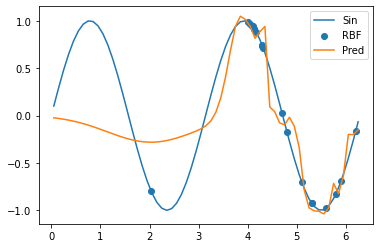

In [83]:

X_train, y_train_sin, y_train_square = get_train_data()
X_test, y_test_sin, y_test_square = get_test_data()

rbf_vq = RBFNet(k=20, delta_epochs=100, cl_epochs=100)
y_pred_train_sin = rbf_vq.fit_and_predict(X_train, y_train_sin, rule="delta", cl="hard")

sin_test_loss = rbf_vq.evaluate_residual_error(X_test, y_test_sin)
y_pred_test_sin = rbf_vq.predict(X_test)

display(pd.DataFrame(rbf_vq.kernel_centers, rbf_vq.kernel_stds))

plot_rbf_with_data(rbf_vq, X_test, y_test_sin)